# Variables impacting the Loan Status and the Borrower Rate

## Investigation Overview

In this investigation, I want to look at the different variables that could have an impact on the loan status and on the borrower rate.

## Dataset Overview

The data consisted of variables caracterising approximately 110,000 loans from the Prosper datasets. Their were originaly around 80 variables caracterising a loan. I decided to focus on only a few variables that I thought could have the most influence on the loan status and the borrower rate. The data was cleaned and tidied due to inconsistencies or missing information.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import loanDFWrangle

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

base_color = sb.color_palette()[0]

# Read propser loan cleaned DataFrame from the created csv file from the data_exploration.ipynb notebook
df_loan_data = pd.read_csv('prosperLoanDataCleanedPostExplor.csv')

# Transform object variables into category
loanDFWrangle.categorizeVariables(df_loan_data)
df_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110242 entries, 0 to 110241
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BorrowerRate            110242 non-null  float64       
 1   Occupation              110242 non-null  category      
 2   IsBorrowerHomeowner     110242 non-null  bool          
 3   StatedMonthlyIncome     110242 non-null  float64       
 4   LoanOriginalAmount      110242 non-null  int64         
 5   LoanOriginationDate     110242 non-null  datetime64[ns]
 6   CreditScoreRangeAvg     110242 non-null  float64       
 7   ListingCategory         110242 non-null  category      
 8   LoanStatusSimplified    110242 non-null  category      
 9   HasPastDelinquencies    110242 non-null  bool          
 10  LoanAmount2IncomeRatio  110242 non-null  float64       
 11  HasRecommendation       110242 non-null  bool          
dtypes: bool(3), category(3), datet

## Distribution of the Loan Status
There are 4 different loan statuses:
* Payments Stopped: The borrower completely stopped his payments.
* Past Due: The borrower is from 1 to 120 days late with his payments.
* Ongoing: The borrower is currently reimbursing the loan.
* Completed: The loan is closed

Most of the loans are ongoing or completed, but there are enough payments stopped statuses to investigate what causes the borrower to stop paying.

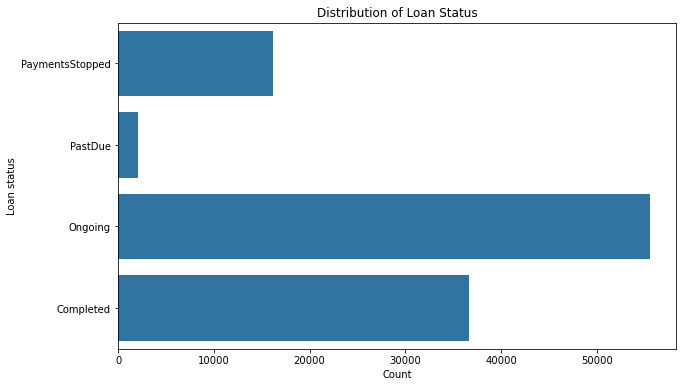

In [2]:
# Count plot of simplified loan statuses
plt.figure(figsize=[10, 6]);
sb.countplot(data=df_loan_data, y='LoanStatusSimplified', color=base_color);
plt.title('Distribution of Loan Status');
plt.ylabel('Loan status');
plt.xlabel('Count');

## Distribution of the Borrower Rate
The rates are evolving from 0.05 to 0.35 with a median at 0.18.
We can notice that the rate distribution is normal and quite symetric, with a slight skew to the right and almost unimodal, except for 2 pikes between 0.3 and 0.35.  

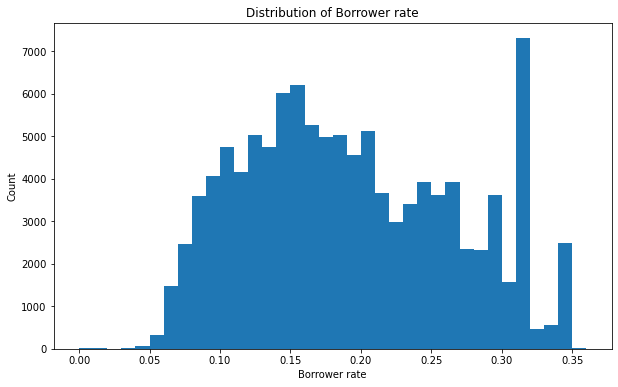

In [3]:
# Histogram of the borrower rate
bin_step = 0.01
bins = np.arange(df_loan_data.BorrowerRate.min(), df_loan_data.BorrowerRate.max() + bin_step, bin_step);

plt.figure(figsize=[10, 6]);
plt.hist(data=df_loan_data, x='BorrowerRate', color=base_color, bins=bins);
plt.title('Distribution of Borrower rate');
plt.ylabel('Count');
plt.xlabel('Borrower rate');

## Borrower Rate versus Loan Status
We can notice that loan with stopped payments and the past due have a higher rates.

That could be explained by the fact that the higher the rate, the higher the price of the loan so borrower with hight rates have more chance to find themselves not able to pay anymore.

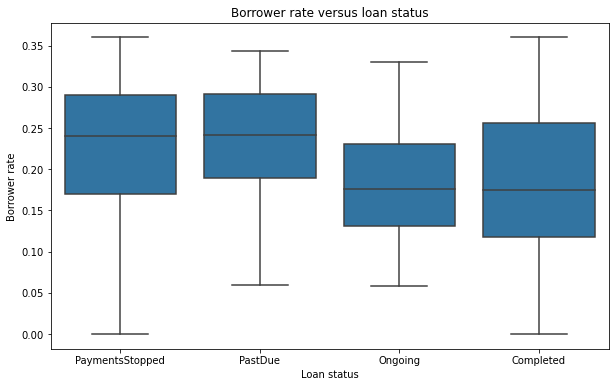

In [4]:
# Box plot of the loan status versus the borrower rate
plt.figure(figsize=[10, 6]);
sb.boxplot(data=df_loan_data, x='LoanStatusSimplified', y='BorrowerRate', color=base_color);
plt.title('Borrower rate versus loan status');
plt.xlabel('Loan status');
plt.ylabel('Borrower rate');

## Loan Status versus Borrower Occupation

From the sorted loan status ratio per occupation heatmap, we can notice that the Students and the profession with lower wages, required knowledge and competence and job security (realtor, waiter...) have the highest payment stopped ratio and that the profession with the highest wages, required knowledge and competence and job security (judge, dentist, pilot...) have the lower payment stopped ratio.

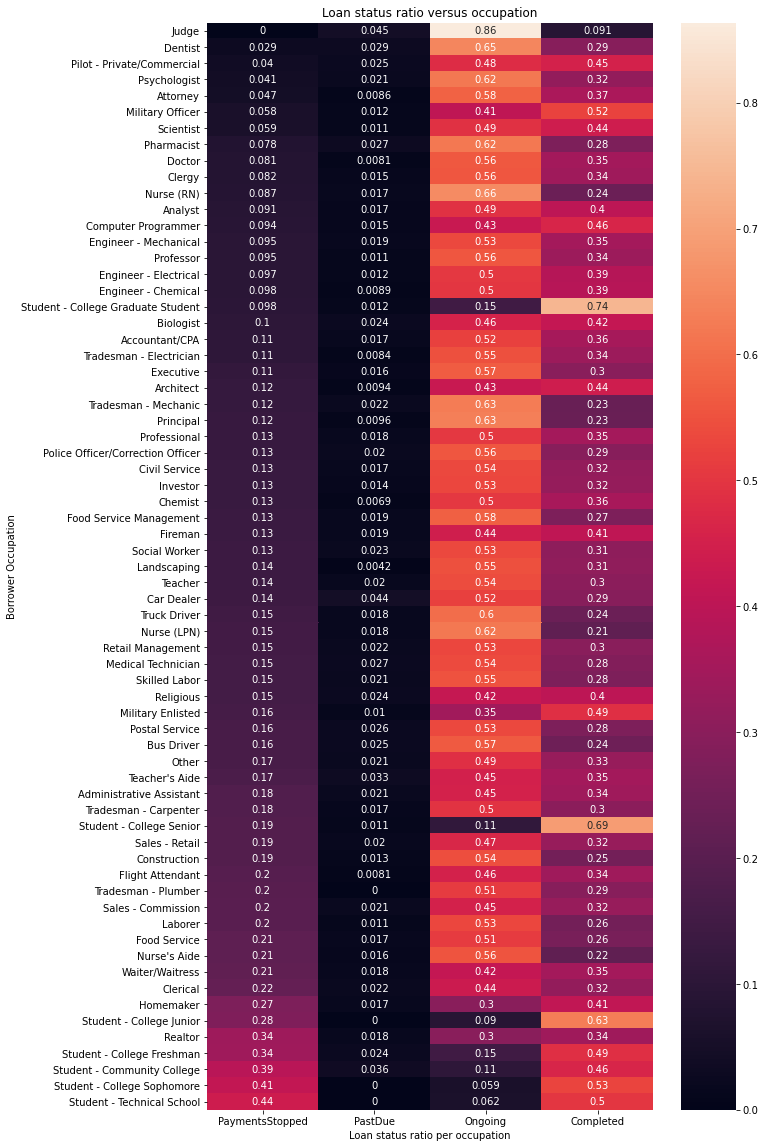

In [5]:
# Retrieve the number of entries for each occupation
ct_counts_occ = df_loan_data.groupby(['Occupation']).size()

# Group the data set by the 2 variable that interest us and 
# store the size divided by the occupation size of the group in a new data frame
ct_counts = df_loan_data.groupby(['Occupation', 'LoanStatusSimplified']).size() / ct_counts_occ
# reset the index and rename it ratio
ct_counts = ct_counts.reset_index(name='ratio')
# Pivot the DF to have the Occupation as index and the count of the different Loan statuses as variable
ct_counts = ct_counts.pivot(index = 'Occupation', columns = 'LoanStatusSimplified', values = 'ratio')

# Sort the DF based on the PaymentsStopped ratio
ct_counts = ct_counts.reindex(ct_counts.PaymentsStopped.sort_values().index, axis=0)

# Plot the previously transformed data frame into a heatmap
plt.figure(figsize=(10, 20))
sb.heatmap(ct_counts, annot = True);
plt.title('Loan status ratio versus occupation');
plt.xlabel('Loan status ratio per occupation');
plt.ylabel('Borrower Occupation');

## Loan Status and Borrower Rate evolution over Time
* The past due and ongoind statuses appeared first in 2011.
* The number of ongoing loan sky roketed from 2011 to 2014.
* The completed and payment stopped loans dropped around 2009 and 2010 (probably because of the financial crisis of 2008).
* The average borrower rate of the payments stopped loans is always ~0.05 higher than and follow the same evolution as the completed loans
* The average borrower rate of the past due loans is always higher than the completed or ongoing loans
* The average borrower rate evolves between 0.15 and 0.27

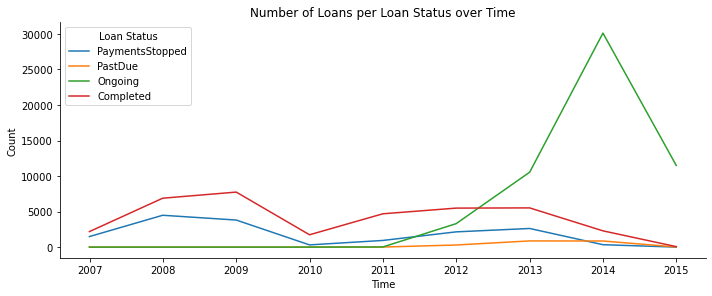

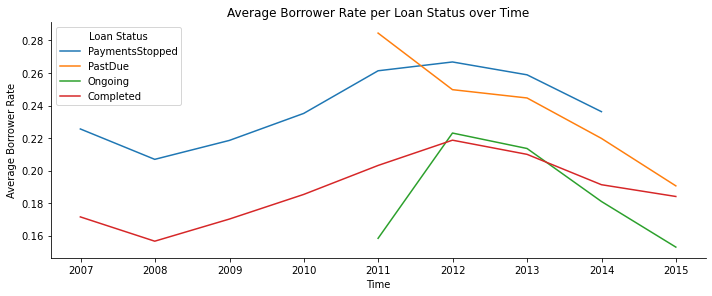

In [6]:
# Create a figure with 2 subplot
#fig, ax = plt.subplots(nrows = 2, figsize = [10,15])

# Group the loans by year and by loan status
df_loan_data_per_year_status = df_loan_data.groupby([pd.Grouper(key='LoanOriginationDate',freq='Y'), 'LoanStatusSimplified'])
# Retrieve the loan counts by year and by loan status
yearly_count_per_status = df_loan_data_per_year_status.BorrowerRate.count()
yearly_count_per_status = yearly_count_per_status.reset_index(name='count')

# Display the loan counts by year for each loan status
g = sb.FacetGrid(data = yearly_count_per_status, hue = 'LoanStatusSimplified', height=4, aspect=2.5);
g.map(plt.errorbar, "LoanOriginationDate", 'count');
leg = plt.legend(title='Loan Status')
plt.title('Number of Loans per Loan Status over Time');
plt.ylabel('Count');
plt.xlabel('Time');

# Borrower rate mean per loan status over time
yearly_rate_mean_per_status = df_loan_data_per_year_status.BorrowerRate.mean()
yearly_rate_mean_per_status = yearly_rate_mean_per_status.reset_index(name='BorrowerAvgRate')

# Facet grid with the loan status as color variable
g = sb.FacetGrid(data = yearly_rate_mean_per_status, hue = 'LoanStatusSimplified', height=4, aspect=2.5);
# Error plot of the borrower avg rate by year for each loan status
g.map(plt.errorbar, "LoanOriginationDate", 'BorrowerAvgRate');
leg = plt.legend(title='Loan Status')
plt.title('Average Borrower Rate per Loan Status over Time');
plt.ylabel('Average Borrower Rate');
plt.xlabel('Time');

## Borrower Rate, Home Ownership and Credit Score
The scatter plot shows us that there is a negative correlation between the Borrower Rate and his Credit score range average. This means that the higher the credit score, the lower the borrower rate.  
We can also notice that the home owner have in general a higher credit score and lower rate.


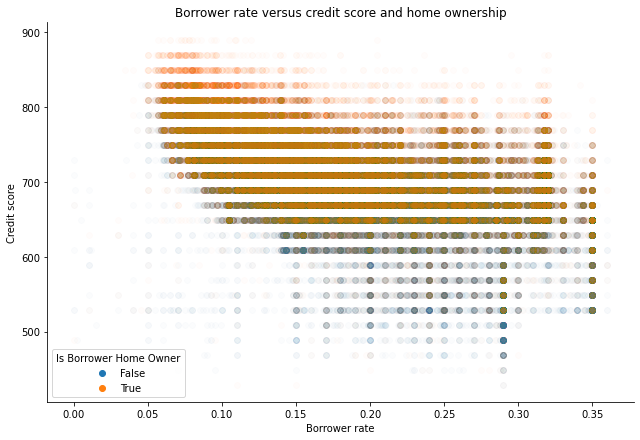

In [7]:
# Facet grid with the borrower home ownership as color variable
g = sb.FacetGrid(data = df_loan_data, hue = 'IsBorrowerHomeowner', height =6, aspect= 1.5);
# Scatter plot of the borrower rate versus his credit score
g.map(plt.scatter, 'BorrowerRate', 'CreditScoreRangeAvg', alpha=1/60);
plt.title('Borrower rate versus credit score and home ownership');
plt.xlabel('Borrower rate');
plt.ylabel('Credit score');
leg = plt.legend(title='Is Borrower Home Owner')
for lh in leg.legendHandles: 
    lh.set_alpha(1)